<a href="https://colab.research.google.com/github/TioDosio/Computer-Vision-L7/blob/master/ISR_MNIST_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

Based on excelent work by **[Daniel Moser (UT Southwestern Medical Center)](https://github.com/AviatorMoser/keras-mnist-tutorial)**, Resources: **[Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/mnist.png" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [5]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import to_categorical                         # NumPy related tools

from keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [6]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook. We can egzamine the interclass variability - how many different ways of writing the same digit there are!

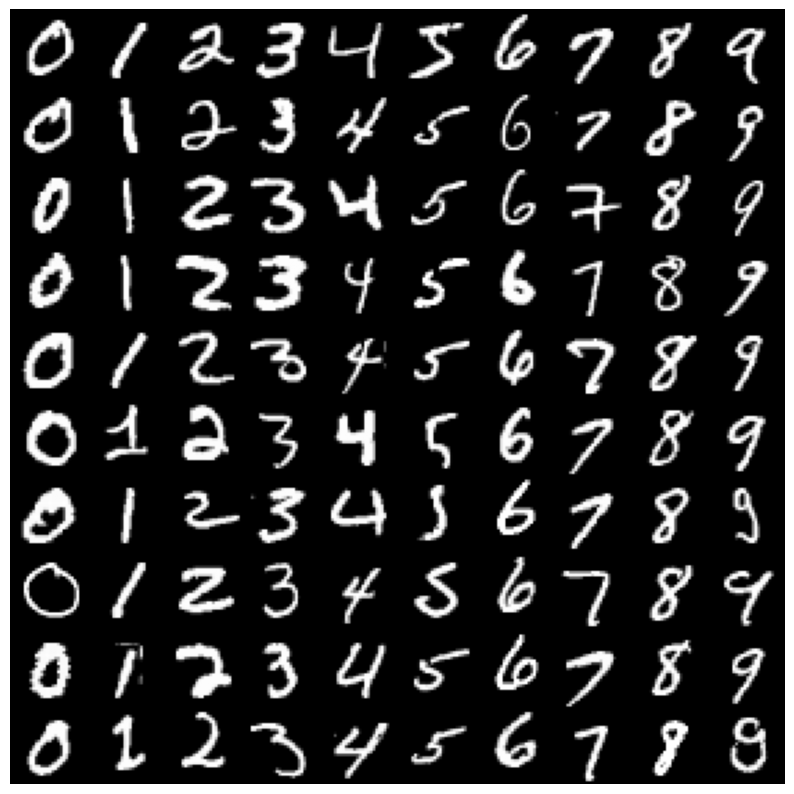

In [7]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

def visualize_classes(X, y):
  for i in range(0, 10):
    img_batch = X[y == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img, cmap='gray')


visualize_classes(X_train, y_train)


Let's examine a single digit a little closer, and print out the array representing the last digit.

In [8]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[-1])

0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0   38   48   48   22    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0   62   97  198  243  254  254  212   27    0    0    0    0    0  0  0  


Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## More input data nalysis


Visualizing high-dimensional data by projecting it into a low-dimensional space is a classic operation that anyone working with data has probably done at least once in their life. There are a huge variety of methods for reducing dimensionality, but one very popular method is t-SNE, a method proposed by Geoffry Hinton’s group back in 2008. [ _more..._ ](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/)

Code by [Zaid Alyafeai](https://github.com/zaidalyafeai/Notebooks) [MIT license]

In [9]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import seaborn as sns

RS=19238

class_names = [ str(clid) for clid in range(10) ]

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, class_names[i], fontsize=15)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

def plot_tsne(X, y):
  print('calculating tsne ...')
  proj = TSNE(random_state=RS).fit_transform(X)
  scatter(proj, y)

calculating tsne ...


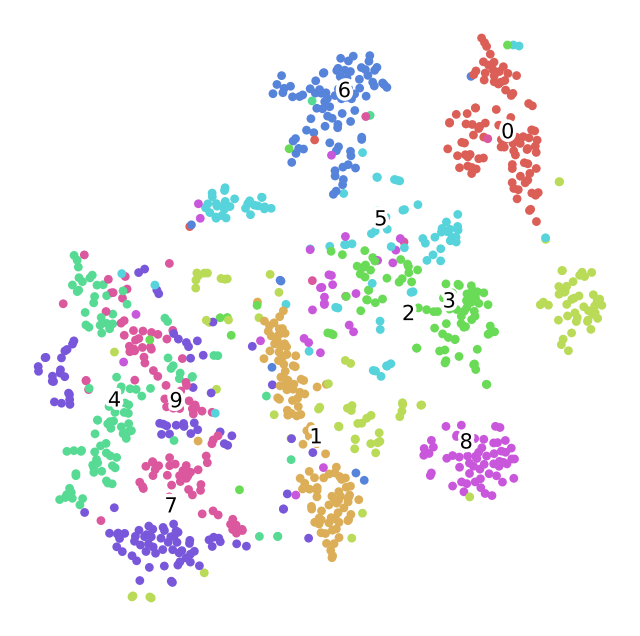

In [10]:
X = np.reshape(X_train, (X_train.shape[0], 28 * 28))[0:1000]
y = y_train[0:1000]
plot_tsne(X, y)

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/flatten.png' >

In [11]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot (categorical) format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [12]:
nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network

<img src="https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/figure.png" />

In [13]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [14]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/relu.jpg' >

In [16]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

## Adding the second hidden layer

In [17]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [18]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [19]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [20]:
# Summarize the built model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/gradient_descent.png" >

<img src = "https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/learning_rate.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/complicated_loss_function.png' >

In [21]:
# Let's use the Adam optimizer for learning
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Train the model!
This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [22]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8619 - loss: 0.4535
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9687 - loss: 0.1045
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9786 - loss: 0.0687
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9829 - loss: 0.0521
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9861 - loss: 0.0440


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [23]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9739 - loss: 0.0873
Test score: 0.07355144619941711
Test accuracy: 0.9782999753952026


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix, without normalization
[[ 967    1    2    3    1    1    1    0    3    1]
 [   0 1130    3    0    0    0    0    0    2    0]
 [   1    0 1017    0    2    0    0    7    5    0]
 [   0    0    3  994    0    5    0    3    3    2]
 [   1    0    3    0  970    0    2    1    1    4]
 [   2    0    0   11    2  863    5    1    5    3]
 [   3    3    2    1   13    3  929    0    4    0]
 [   1    2    6    0    6    0    0 1007    2    4]
 [   3    1    3    6    3    1    0    4  950    3]
 [   2    5    0    2   36    1    0    5    2  956]]


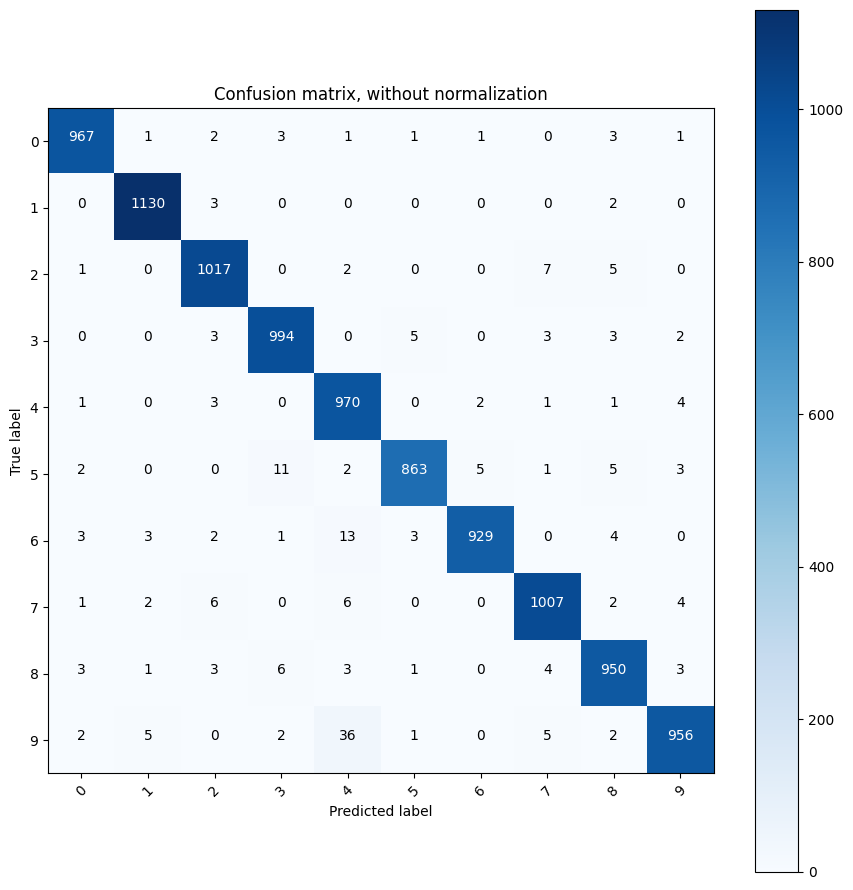

In [25]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()


**Correct predictions**

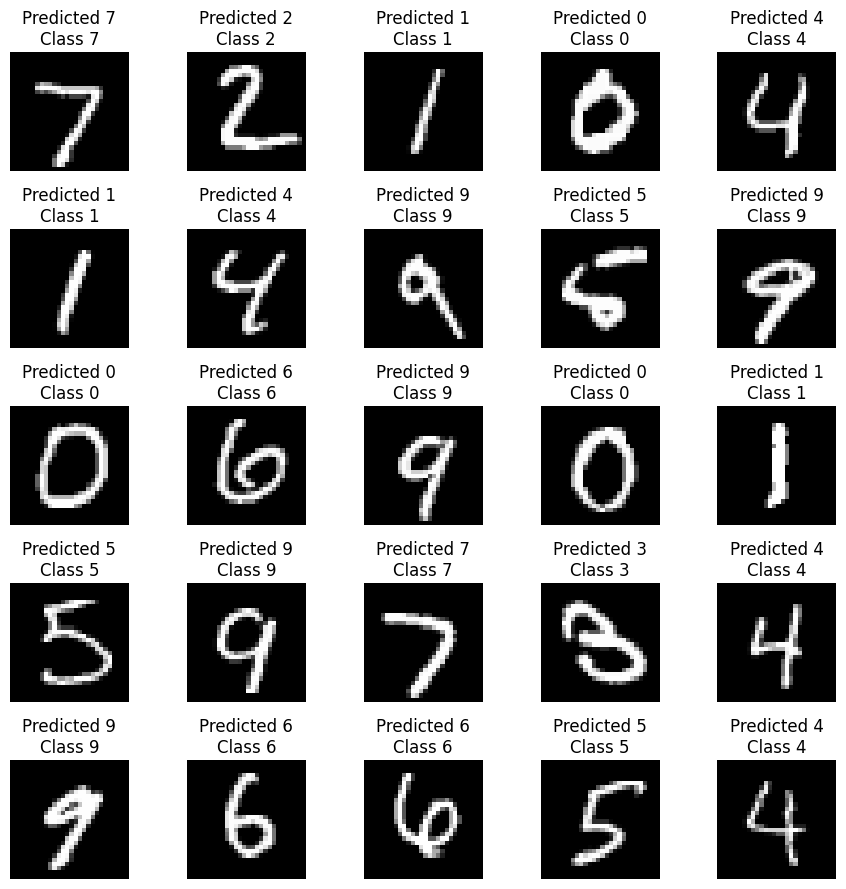

In [26]:
def show_samples(indices, preds, images, labels, count=3, names = []):
    plt.figure()
    for i, sample in enumerate(indices[:count**2]):
        plt.subplot(count,count,i+1)
        plt.imshow(images[sample].reshape(28,28), cmap='gray', interpolation='none')
        plt.axis('off')
        if len(names) > 0:
          plt.title("Predicted {}\nClass {}".format(names[int(preds[sample])], names[int(labels[sample])]))
        else:
          plt.title("Predicted {}\nClass {}".format(preds[sample], labels[sample]))

    plt.tight_layout()

show_samples(correct_indices, predicted_classes, X_test, y_test, 5)

**Wrong predictions**

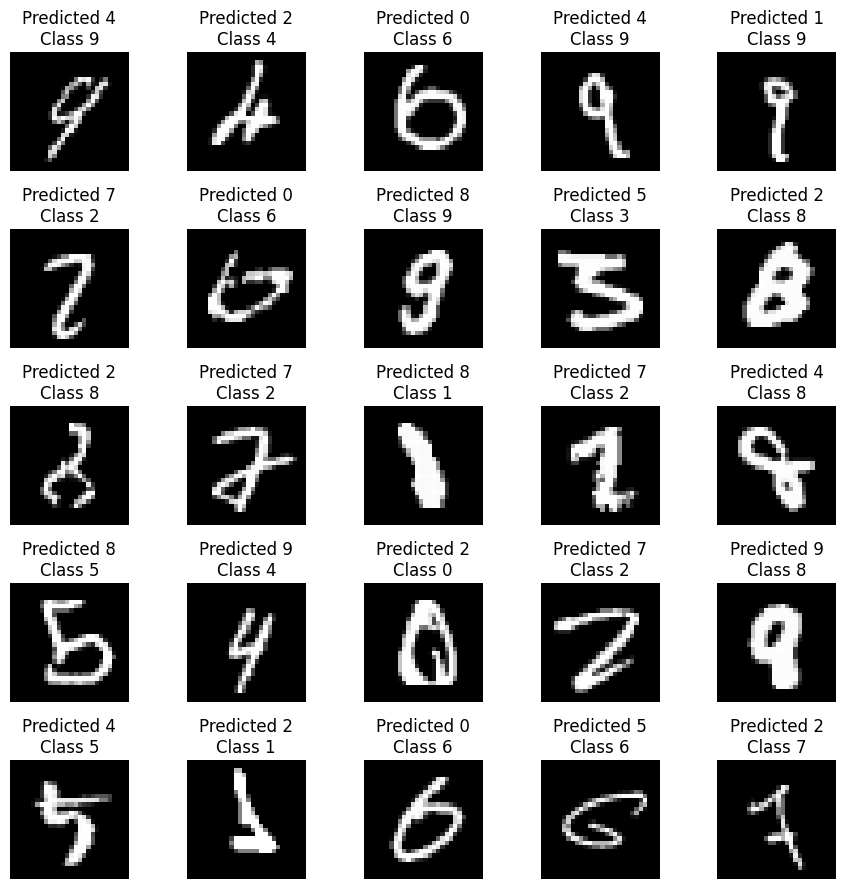

In [27]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5)

# Try experimenting with the batch size!

   * How does increasing the batch size to 10,000 affect the training time and test accuracy?
   * How about a batch size of 32?
   * Is there any difference in results between the students? If so - why?
   * Experiment with the learning rate in the optimizer

# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'https://github.com/wut-mpg/keras-mnist-tutorial/raw/master/go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [28]:
# import some additional tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

In [29]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [30]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [31]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [32]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(16, (5, 5), input_shape=(28,28,1))) # 16 different 5x5 kernels -- so 16 feature maps
model.add(Activation('relu') )                       # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
model.add(Conv2D(32, (5, 5)))                        # 32 different 5x5 kernels -- so 32 feature maps
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

model.add(Flatten())                                 # Flatten final output matrix into a vector

# Fully Connected Layer
model.add(Dense(128))                                # 128 FC nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer
model.add(Dense(10))                                 # final 10 FC nodes
model.add(Activation('softmax'))                     # softmax activation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 32)            │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,202 (313.29 KB)

 Trainable params: 80,202 (313.29 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# we'll use the same optimizer
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

In [36]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [37]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit(train_generator, steps_per_epoch=48000//128, epochs=5, verbose=1, validation_data=valid_generator, validation_steps = 12000 // 128)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.7415 - loss: 0.8333 - val_accuracy: 0.9535 - val_loss: 0.1544
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9688 - val_loss: 0.0967
Epoch 3/5


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.9538 - loss: 0.1468 - val_accuracy: 0.9656 - val_loss: 0.1080
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9792 - val_loss: 0.0734
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.9674 - loss: 0.1027 - val_accuracy: 0.9714 - val_loss: 0.0890


In [38]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9848 - loss: 0.0488
Test score: 0.03979691118001938
Test accuracy: 0.9876000285148621


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Confusion matrix, without normalization
[[ 973    0    3    0    1    0    1    1    1    0]
 [   0 1131    2    0    0    0    1    1    0    0]
 [   0    1 1029    0    0    0    0    2    0    0]
 [   0    1    0  999    0    6    0    2    2    0]
 [   0    0    2    0  979    0    0    0    0    1]
 [   0    0    0    6    0  884    1    1    0    0]
 [   2    2    1    1    0    3  946    0    3    0]
 [   0    5    8    2    3    0    0 1005    2    3]
 [   1    0    4    2    5    2    2    1  955    2]
 [   1    5    0    5   12    6    0    4    1  975]]


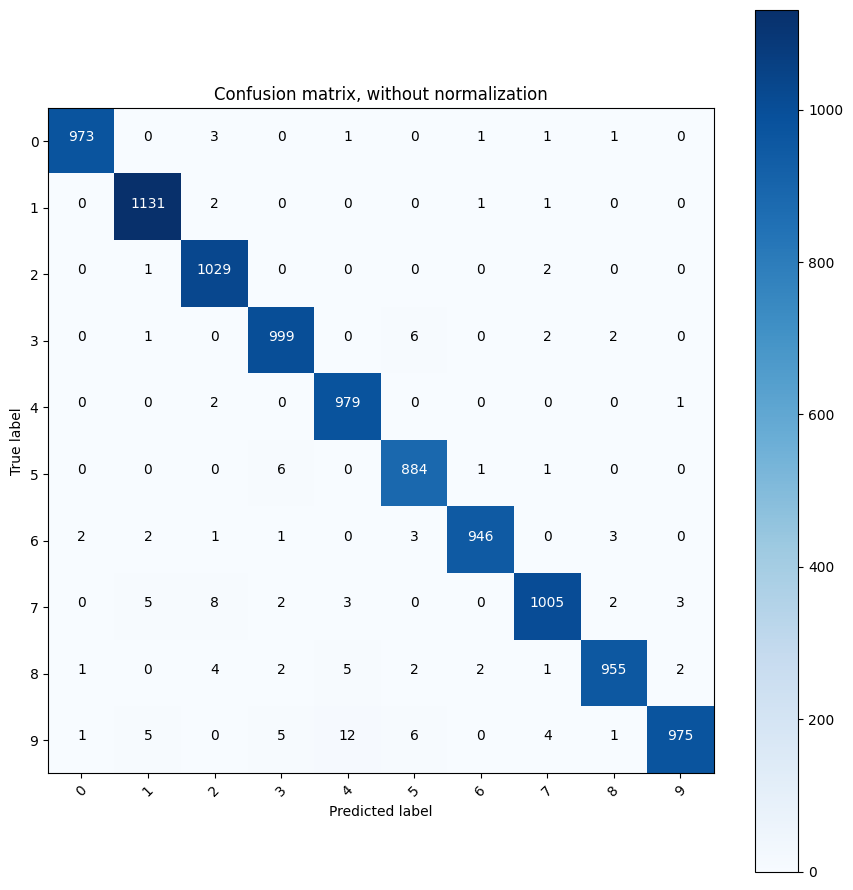

In [39]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

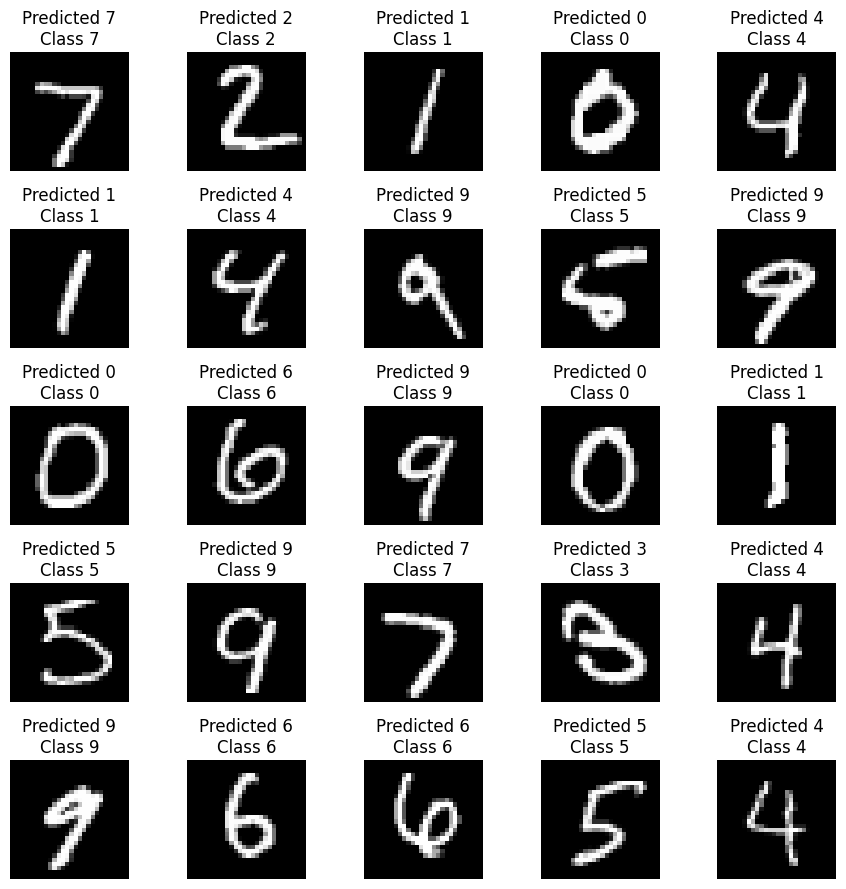

In [40]:
show_samples(correct_indices, predicted_classes, X_test, y_test, 5)

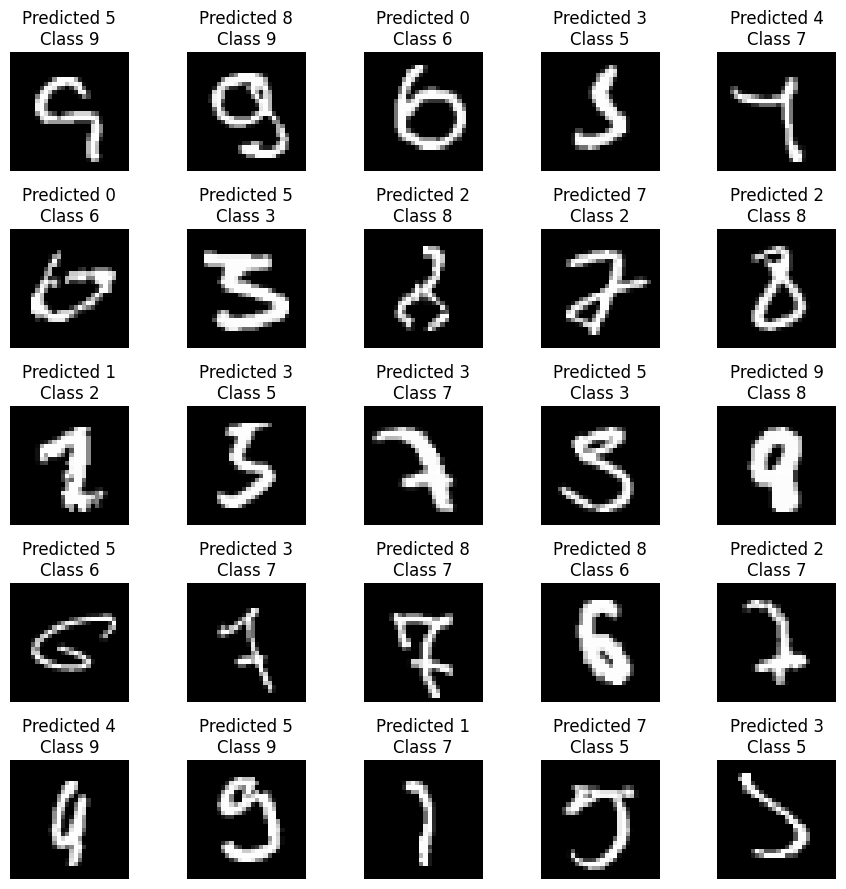

In [41]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5)

## Great results!

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [42]:
from keras import backend as K

def visualize(model, layer, img, r, c):
  from keras import Model
  # expand dimensions so that it represents a single 'sample'
  img = np.expand_dims(img, axis=0)
  outputs = [layer.output]
  model = Model(inputs=model.inputs, outputs=outputs)
  # get feature map for first hidden layer
  feature_maps = model.predict(img)
  for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(r):
      for _ in range(c):
        # specify subplot and turn of axis
        ax = plt.subplot(r, c, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(fmap[:, :, ix-1], cmap='gray')
        ix += 1


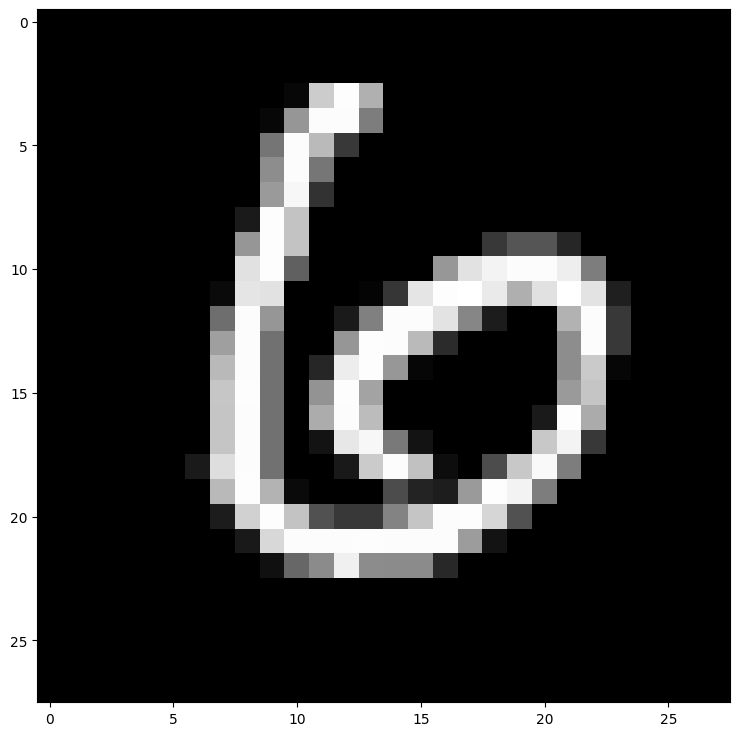

In [43]:
plt.figure()
img = X_test[11]
plt.imshow(img[:,:,0], cmap='gray', interpolation='none')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


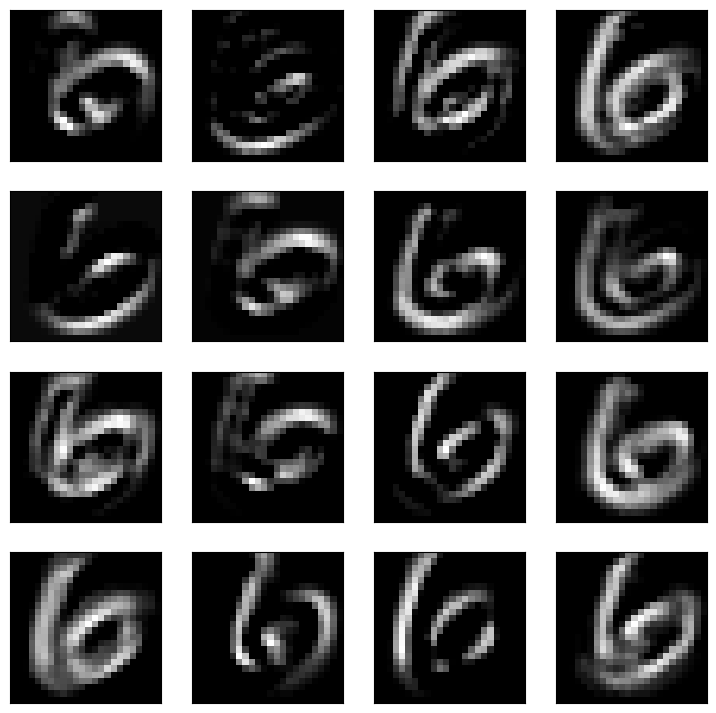

In [44]:
visualize(model, model.layers[1], img, 4, 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


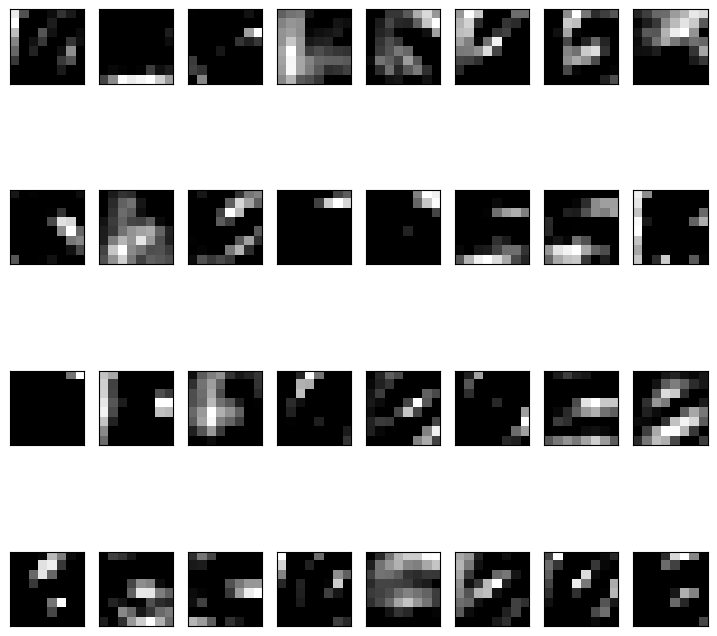

In [45]:
visualize(model, model.layers[4], img, 4, 8)

# Test on different dataset

Your task is to prepare the image classifier for different dataset, consisting of small, hand-drawn objects. The strukcture of the set is similar to the MNIST, i.e. the same size of the images.

First, we download the dataset meta information, select set of ten classes and use them as our data.

In [74]:
!wget https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt

--2025-01-16 17:53:15--  https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2791 (2.7K) [text/plain]
Saving to: ‘categories.txt.1’

categories.txt.1    100%[===================>]   2.73K  --.-KB/s    in 0s      

2025-01-16 17:53:15 (29.9 MB/s) - ‘categories.txt.1’ saved [2791/2791]



In [75]:
import os
import urllib

def download_and_load(class_names, test_split = 0.2, max_items_per_class = 10000):
  root = 'data'
  if not os.path.exists(root):
    os.makedirs(root)

  print('downloading ...')
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in class_names:
    cc = c.replace('_', '%20')
    path = base+cc+'.npy'
    print(path)
    if not os.path.exists(f'{root}/{cc}.npy'):
      urllib.request.urlretrieve(path, f'{root}/{cc}.npy')
    else:
      print("Already downloaded")
  print('loading ...')

  #initialize variables
  x = np.empty([0, 784])
  y = np.empty([0])

  #load each data file
  for idx, file in enumerate(class_names):
      file = file.replace('_', '%20')
      data = np.load(f'{root}/{file}.npy')
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

  data = None
  labels = None

  #randomize the dataset
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #reshape and inverse the colors
  x = 255 - np.reshape(x, (x.shape[0], 28, 28))

  #separate into training and testing
  test_size  = int(x.shape[0]/100*(test_split*100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]

  print('Training Data : ', x_train.shape[0])
  print('Testing  Data : ', x_test.shape[0])
  return x_train, y_train, x_test, y_test

You can randomize the choice of classes by changing the SEED value. After you think you have good, working model, you can pick "hard" classes, by uncommenting the fixed class names below.

In [76]:
# set your random seed value, put any number here
RANDOM_SEED = 1234

['pizza', 'cannon', 'ambulance', 'bulldozer', 'swing_set', 'baseball_bat', 'zebra', 'bridge', 'cactus', 'matches']
downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cannon.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bulldozer.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swing%20set.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/zebra.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bridge.npy
Already downloaded
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cactus.np

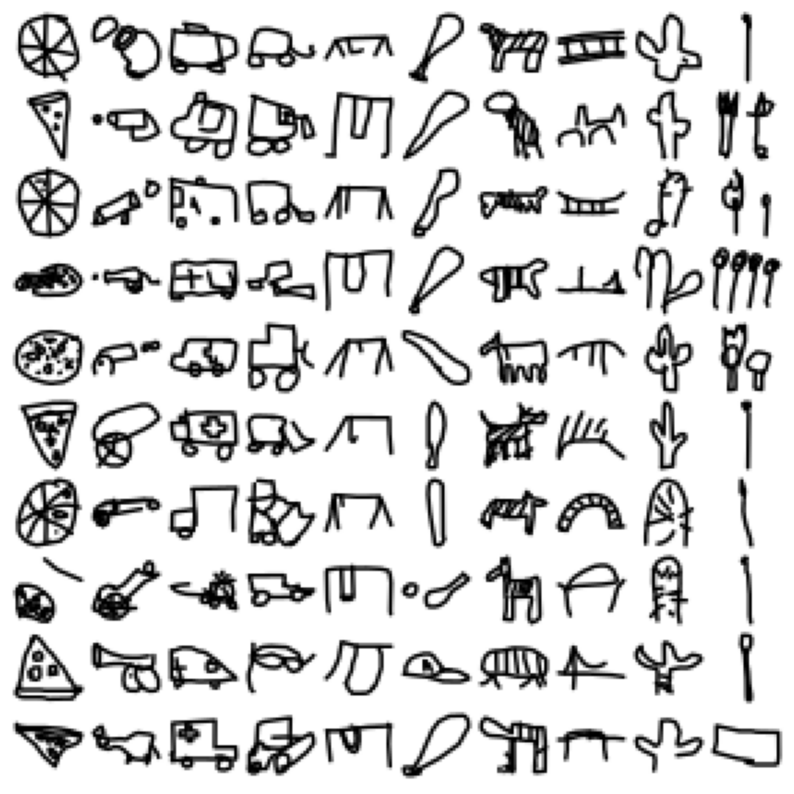

In [77]:
import random

with open('categories.txt') as f:
    all_class_names = f.readlines()


random.seed(RANDOM_SEED)

all_class_names = [x.strip().replace(' ', '_') for x in all_class_names]

nb_classes = 10

# select random 10 classes
class_names = random.sample(all_class_names, nb_classes)

# you can also try those "hard" classes instead
# class_names = ['wheel', 'pizza', 'smiley_face', 'apple', 'potato', 'basketball', 'soccer_ball', 'brain', 'clock', 'circle']

print(class_names)

X_train, y_train, X_test, y_test = download_and_load(class_names)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

visualize_classes(X_train, y_train)

## Create the model

We start from the model structure similar to the MNIST one. Your task is to modify this model so that it achieves at least 0.9 accuracy on the selected dataset (in testing mode).

OG: 2 conv com (5,5) kernel size 10ep - test=0.86

1º: 2 conv com (3,3) kernel size 10ep - test=0.86

2º 2 conv com filter size 32 64 20ep - test=0.90

3º dropout com 2º - test=0.88

4º 2 conv with 3x3 kernel = 0.916

5º 2 conv with 3x3 kernel com 1 dense 128 e 1 dense 64



In [86]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 16 different 5x5 kernels -- so 16 feature maps
model.add(Activation('relu') )                       # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

# Convolution Layer 2
model.add(Conv2D(64, (3, 3)))                        # 32 different 5x5 kernels -- so 32 feature maps
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))             # Pool the max values over a 2x2 kernel

model.add(Flatten())                                 # Flatten final output matrix into a vector

# Fully Connected Layer
model.add(Dense(256))                                # 64 FC nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer
model.add(Dense(10))                                 # final 10 FC nodes
model.add(Activation('softmax'))                     # softmax activation


# we'll use the same optimizer
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [88]:
history = model.fit(train_generator, steps_per_epoch=64000//128, epochs=25, verbose=1, validation_data=valid_generator, validation_steps = 16000 // 128)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 167ms/step - accuracy: 0.5720 - loss: 1.2977 - val_accuracy: 0.7913 - val_loss: 0.6876
Epoch 2/25


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 169ms/step - accuracy: 0.8125 - loss: 0.6143 - val_accuracy: 0.8372 - val_loss: 0.5505
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 166ms/step - accuracy: 0.8433 - loss: 0.5166 - val_accuracy: 0.8441 - val_loss: 0.5188
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 166ms/step - accuracy: 0.8627 - loss: 0.4566 - val_accuracy: 0.8724 - val_loss: 0.4404
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.8748 - loss: 0.4130 - val_accuracy: 0.8782 - val_loss: 0.4171
Epoch 10/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/2

In [89]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9113 - loss: 0.3317
Test score: 0.3318600058555603
Test accuracy: 0.911549985408783


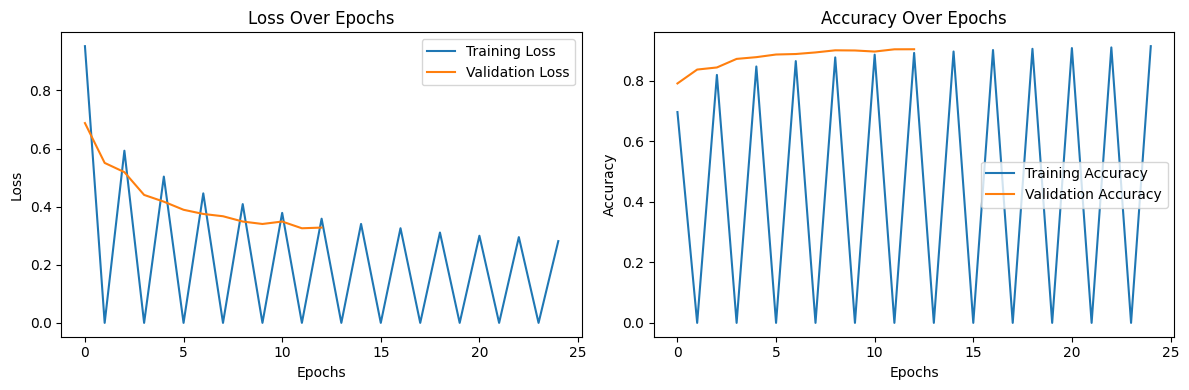

In [90]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
Confusion matrix, without normalization
[[1907    9    7   10    0    4    7    8    1   11]
 [  11 1737   38   74    4   12   34   41    6   16]
 [   7   18 1872   50    5    1    5    8    1   12]
 [  16   32  118 1719    1    6   23    6    4   16]
 [   2    9    9   21 1832   10   16   60    5   13]
 [  18   75    4   23    4 1800   11   31   18   52]
 [   9   20   18   13    1    4 1919   24    4   13]
 [  13   25   30   29   13    6   27 1852    7   19]
 [  12   13    9   37    1    6   19   13 1920   25]
 [  24   50   32   75   16   44   40   46   29 1673]]


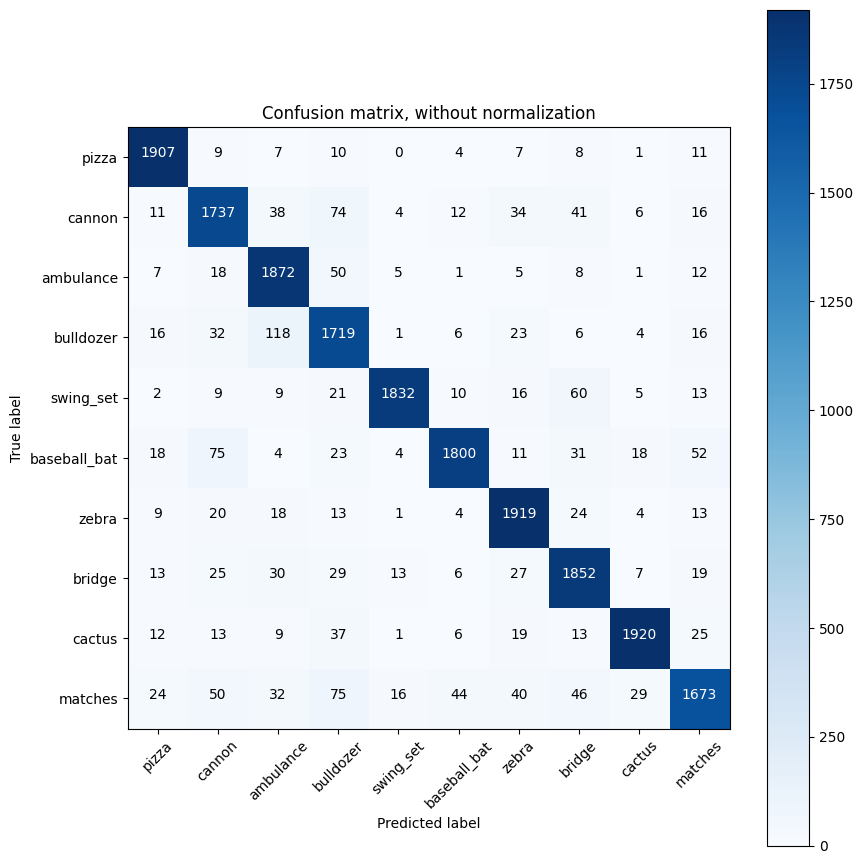

In [91]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

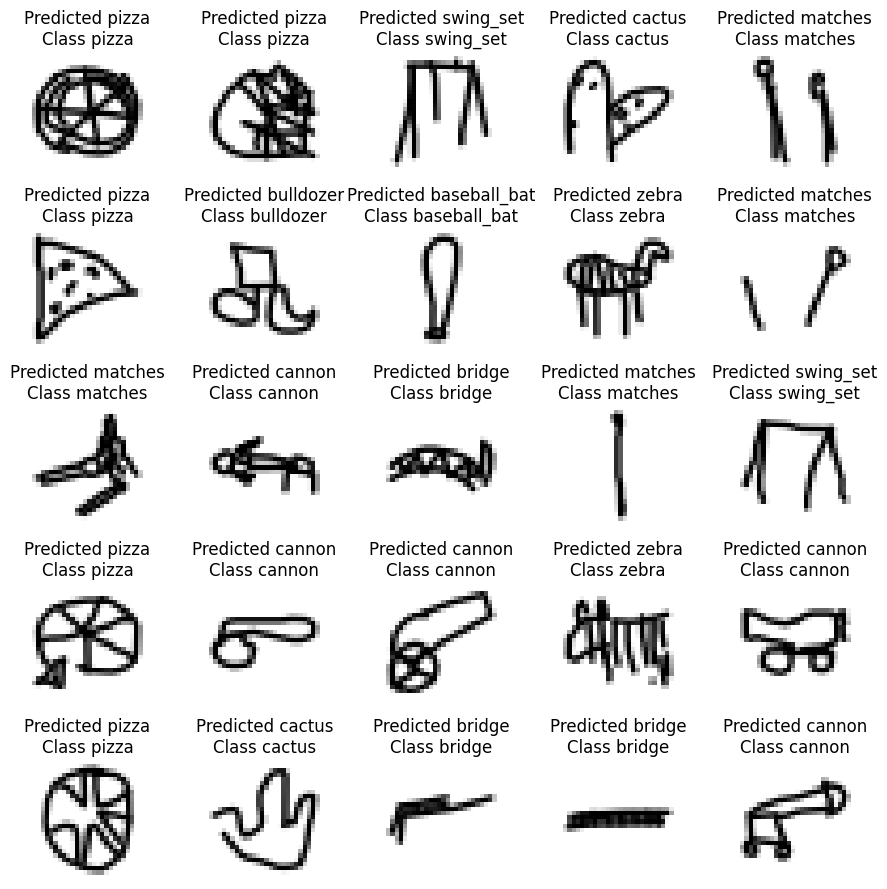

In [92]:
show_samples(correct_indices, predicted_classes, X_test, y_test, 5, class_names)

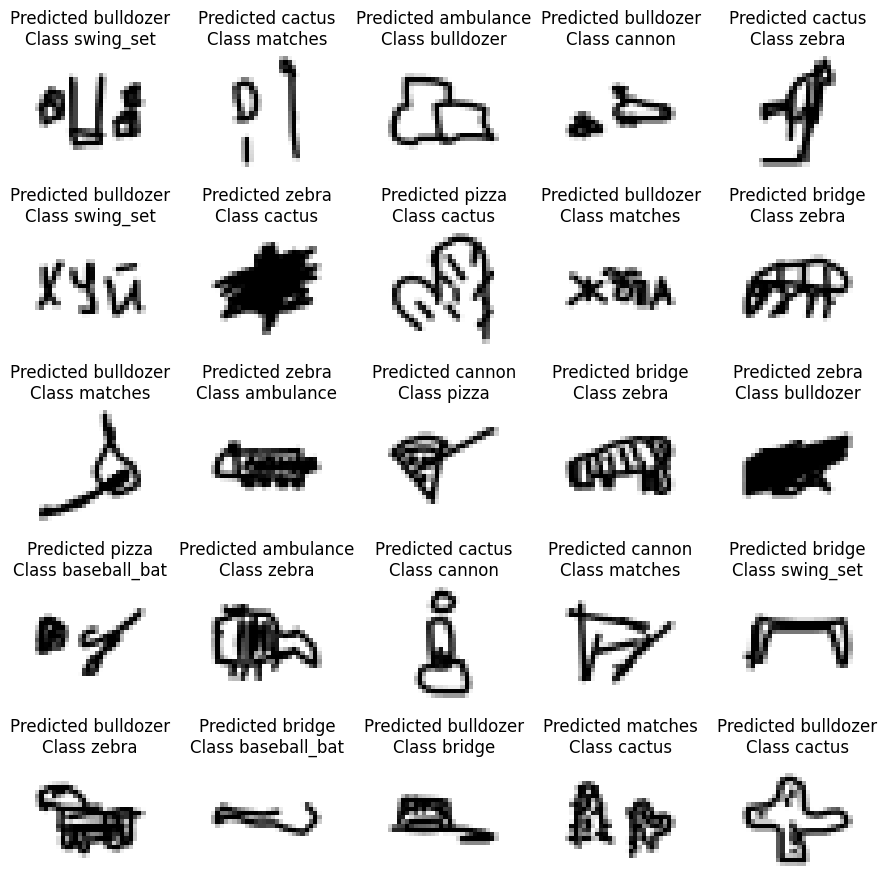

In [93]:
show_samples(incorrect_indices, predicted_classes, X_test, y_test, 5, class_names)